In [1]:
import nltk

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import spacy
from nltk.corpus import stopwords

import regex as re
import string
import gensim

from wordcloud import WordCloud
from sklearn.model_selection import train_test_split

In [3]:
from nltk import word_tokenize 
from nltk.util import ngrams

In [166]:
df = pd.read_csv("train.csv")
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# Target count distribution

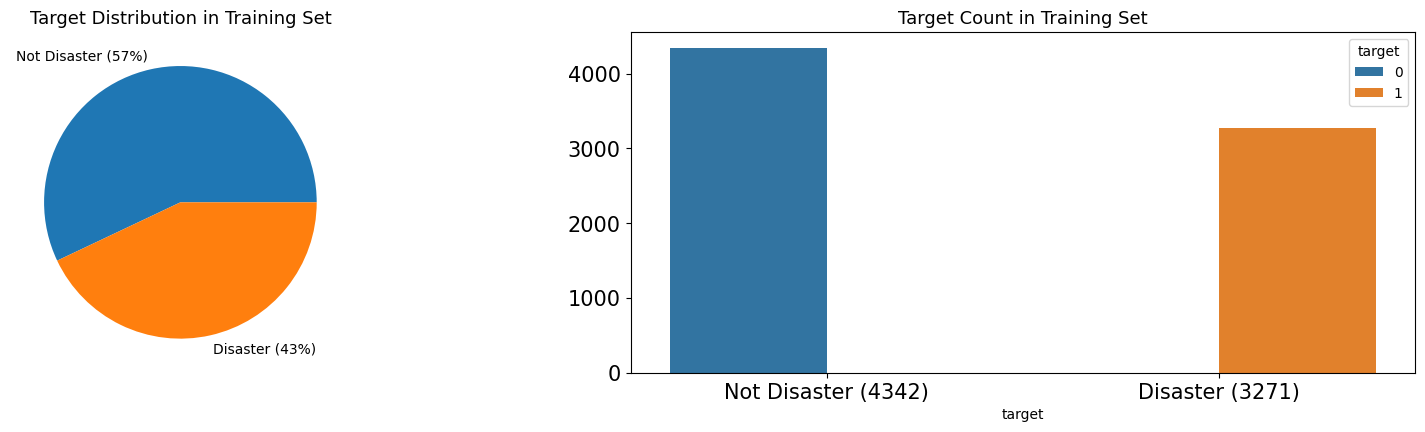

In [167]:
fig, axes = plt.subplots(ncols=2, figsize=(17, 4), dpi=100)
plt.tight_layout()

df.groupby('target').count()['id'].plot(kind='pie', ax=axes[0], labels=['Not Disaster (57%)', 'Disaster (43%)'])
sns.countplot(x=df['target'], hue=df['target'], ax=axes[1])

axes[0].set_ylabel('')
axes[1].set_ylabel('')
axes[1].set_xticklabels(['Not Disaster (4342)', 'Disaster (3271)'])
axes[0].tick_params(axis='x', labelsize=15)
axes[0].tick_params(axis='y', labelsize=15)
axes[1].tick_params(axis='x', labelsize=15)
axes[1].tick_params(axis='y', labelsize=15)

axes[0].set_title('Target Distribution in Training Set', fontsize=13)
axes[1].set_title('Target Count in Training Set', fontsize=13)

plt.show()

# Cleaning and preprocessing

In [168]:
# To make it more realistic, we shouldn't use the keyword as feature, but we can use to stratify the data for the train and test sets later on
# Those with NaN, replace with others
df['keyword'] = df['keyword'].fillna('others')
LOCATION_KEYS = df['location'].value_counts().keys()
df['location'] = df['location'].apply(lambda x: x if x in LOCATION_KEYS else 'Others')


Create meta-features

In [169]:
# Create meta features from text
STOPWORDS = set(nltk.corpus.stopwords.words('english'))
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
df['unique_word_count'] = df['text'].apply(lambda x: len(set(str(x).split())))
df['stop_word_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
df['mean_word_length'] = df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
df['punctuation_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
df['url_count'] = df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
df['hashtag_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
df['mention_count'] = df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

In [170]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [171]:
df['text'] = df['text'].apply(lambda x:clean_text(x))

In [172]:
df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count,url_count,hashtag_count,mention_count
0,1,others,Others,our deeds are the reason of this earthquake ma...,1,13,13,6,4.384615,69,1,0,1,0
1,4,others,Others,forest fire near la ronge sask canada,1,7,7,0,4.571429,38,1,0,0,0
2,5,others,Others,all residents asked to shelter in place are be...,1,22,20,11,5.090909,133,3,0,0,0
3,6,others,Others,people receive wildfires evacuation orders in...,1,8,8,1,7.125000,65,2,0,1,0
4,7,others,Others,just got sent this photo from ruby alaska as s...,1,16,15,7,4.500000,88,2,0,2,0


In [173]:
# Check for duplicates
df_mislabeled = df.groupby(['text']).nunique().sort_values(by='target', ascending=False)
df_mislabeled = df_mislabeled[df_mislabeled['target'] > 1]['target'] 
df_mislabeled

text
detonation fashionable mountaineering electronic watch waterresistant couples leisure tabû                        2
hellfire is surrounded by desires so be careful and donûªt let your desires control you afterlife                 2
how is it one careless match can start a forest fire but it takes a whole box to start a campfire                  2
truth\r\rnews\rbbc\rcnn\rislam\rtruth\rgod\risis\rterrorism\rquran\rlies                                           2
world war ii book lightning joe an autobiography by general j lawton collins                                       2
                                                                                                                  ..
why are you deluged with low selfimage take the quiz                                                               2
i liked a youtube video from itsjustinstuart  gun range mayhem                                                     2
foodscare  nestleindia slips into loss after magginoodle ba

In [174]:
# Tweets that are truly disaster tweets are:
# .potus #strategicpatience is a strategy for #genocide; refugees; idp internally displaced people; horror; etc. https://t.co/rqwuoy1fm4        2
# cleared:incident with injury:i-495 inner loop exit 31 - md 97/georgia ave silver spring                                                       2
# who is bringing the tornadoes and floods. who is bringing the climate change. god is after america he is plaguing her #farrakhan #quote       2
# rt notexplained: the only known image of infamous hijacker d.b. cooper. http://t.co/jlzk2hdetg                                                2
# caution: breathing may be hazardous to your health.                                                                                           2

# Drop those tweets
not_mislabelled = ['.potus', 'cleared:incident', 'who is bringing', 'rt notexplained', 'caution: breathing']
df_mislabeled = df_mislabeled[~df_mislabeled.index.str.contains('|'.join(not_mislabelled))]
df_mislabeled.shape

(72,)

In [175]:
# Label the rest of df_mislabelled as 0
df.loc[df['text'].isin(df_mislabeled.index), 'target'] = 0

# Remove any duplicates
df = df.drop_duplicates(subset=['text'], keep='first')
df.shape

(6918, 14)

In [176]:
# reset index because some are missing
df= df.reset_index(drop=True)

In [177]:
df['tokenized'] = np.nan

for i in range(len(df)):
    df['tokenized'][i]= list(gensim.utils.tokenize(df['text'][i]))
    

C:\Users\chinj\AppData\Local\Temp\ipykernel_8980\461379296.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['tokenized'][i]= list(gensim.utils.tokenize(df['text'][i]))
c:\Users\chinj\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [178]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]


In [179]:
df['nostopwords_text'] = df['tokenized'].apply(lambda x:remove_stopword(x))

In [180]:
df.head()

,id,keyword,location,text,target,word_count,unique_word_count,stop_word_count,mean_word_length,char_count,punctuation_count,url_count,hashtag_count,mention_count,tokenized,nostopwords_text
0,1,others,Others,our deeds are the reason of this earthquake ma...,1,13,13,6,4.384615,69,1,0,1,0,"[our, deeds, are, the, reason, of, this, earth...","[deeds, reason, earthquake, may, allah, forgiv..."
1,4,others,Others,forest fire near la ronge sask canada,1,7,7,0,4.571429,38,1,0,0,0,"[forest, fire, near, la, ronge, sask, canada]","[forest, fire, near, la, ronge, sask, canada]"
2,5,others,Others,all residents asked to shelter in place are be...,1,22,20,11,5.090909,133,3,0,0,0,"[all, residents, asked, to, shelter, in, place...","[residents, asked, shelter, place, notified, o..."
3,6,others,Others,people receive wildfires evacuation orders in...,1,8,8,1,7.125000,65,2,0,1,0,"[people, receive, wildfires, evacuation, order...","[people, receive, wildfires, evacuation, order..."
4,7,others,Others,just got sent this photo from ruby alaska as s...,1,16,15,7,4.500000,88,2,0,2,0,"[just, got, sent, this, photo, from, ruby, ala...","[got, sent, photo, ruby, alaska, smoke, wildfi..."


## Obtaining unigrams

In [181]:
def gen_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(' ') if token != '' if token not in stopwords.words('english')]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [' '.join(ngram) for ngram in ngrams]


# Unigrams
disaster_unigrams = defaultdict(int)
nondisaster_unigrams = defaultdict(int)

for i in range(len(df)):
    if df['target'][i]== 1:
        for word in gen_ngrams(df['text'][i], n_gram=1):
            disaster_unigrams[word] += 1
    else:
        for word in gen_ngrams(df['text'][i], n_gram=1):
            nondisaster_unigrams[word] += 1
        
# Bigrams
disaster_bigrams = defaultdict(int)
nondisaster_bigrams = defaultdict(int)

for i in range(len(df)):
    if df['target'][i]== 1:
        for word in gen_ngrams(df['text'][i], n_gram=2):
            disaster_bigrams[word] += 1
    else:
        for word in gen_ngrams(df['text'][i], n_gram=2):
            nondisaster_bigrams[word] += 1
        
df_disaster_unigrams = pd.DataFrame(sorted(disaster_unigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_unigrams = pd.DataFrame(sorted(nondisaster_unigrams.items(), key=lambda x: x[1])[::-1])
        
df_disaster_bigrams = pd.DataFrame(sorted(disaster_bigrams.items(), key=lambda x: x[1])[::-1])
df_nondisaster_bigrams = pd.DataFrame(sorted(nondisaster_bigrams.items(), key=lambda x: x[1])[::-1])


In [182]:
df_disaster_unigrams.head()

,0,1
0,fire,162
1,news,110
2,amp,105
3,police,95
4,via,93


# Top 20 unigrams and bigrams

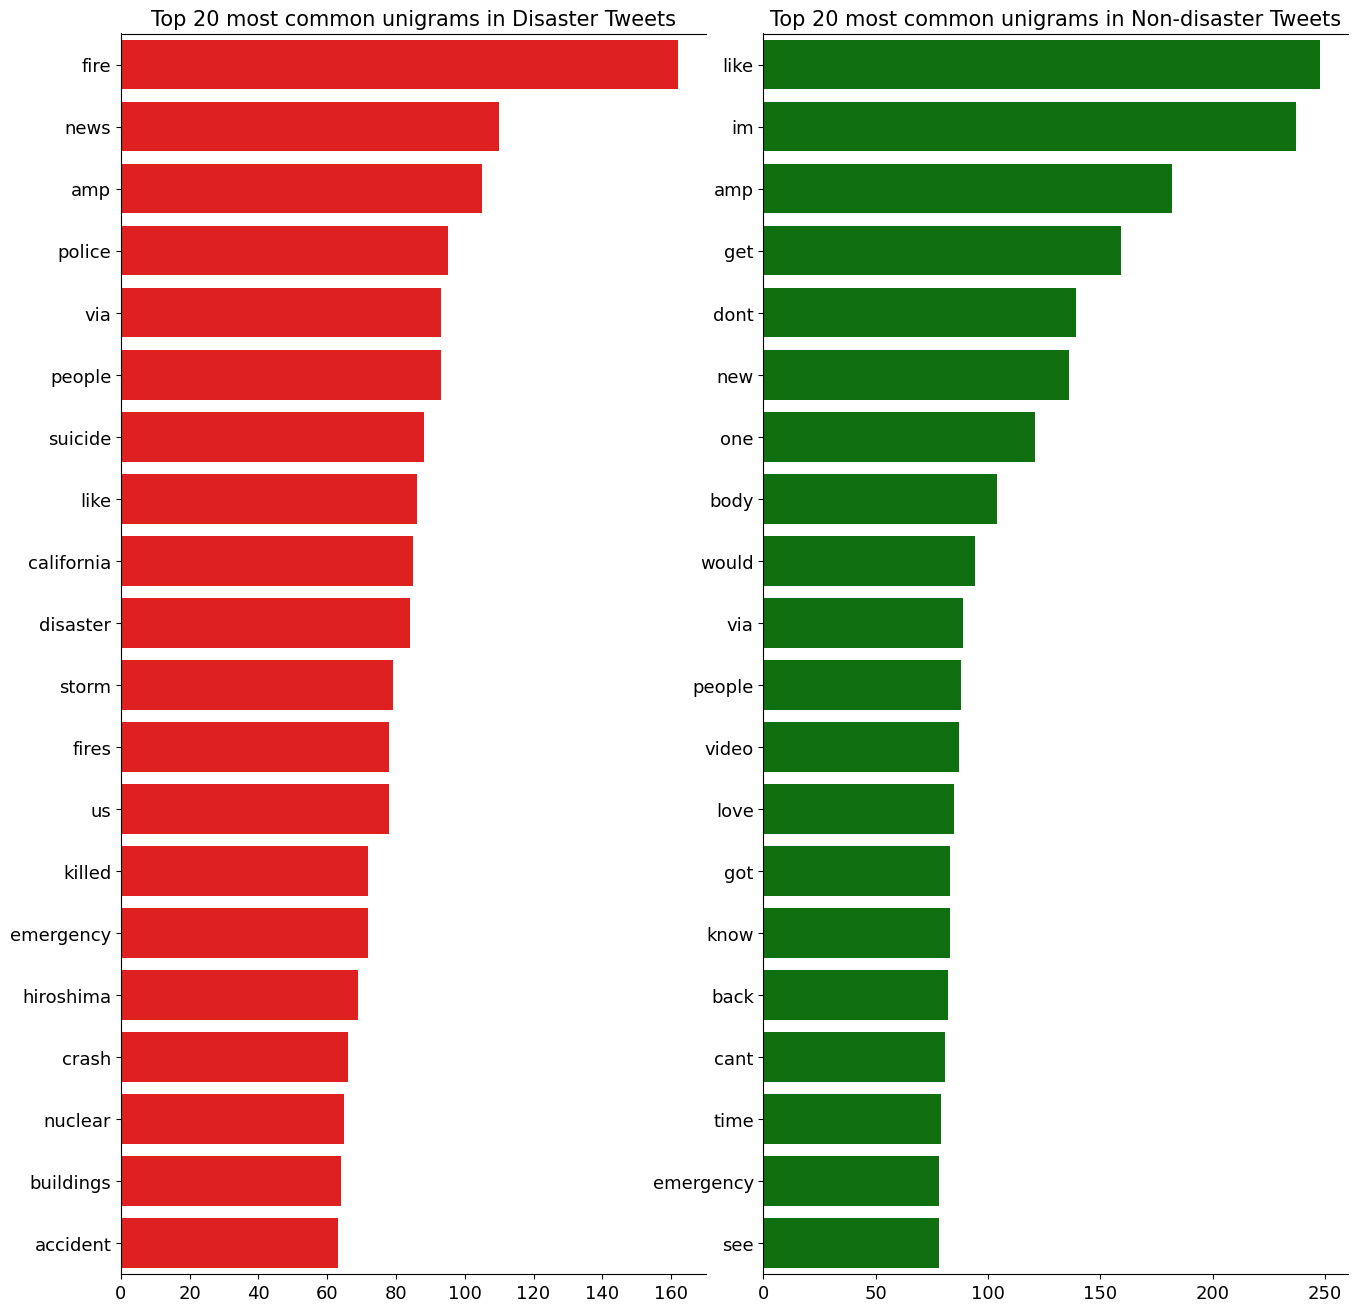

In [129]:
N= 20

fig, axes = plt.subplots(ncols=2, figsize=(13,13), dpi=100)
plt.tight_layout()

with sns.plotting_context( font_scale=4):
    sns.barplot(y=df_disaster_unigrams[0].values[:N], x=df_disaster_unigrams[1].values[:N], ax=axes[0], color='red')
    sns.barplot(y=df_nondisaster_unigrams[0].values[:N], x=df_nondisaster_unigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common unigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common unigrams in Non-disaster Tweets', fontsize=15)

plt.show()

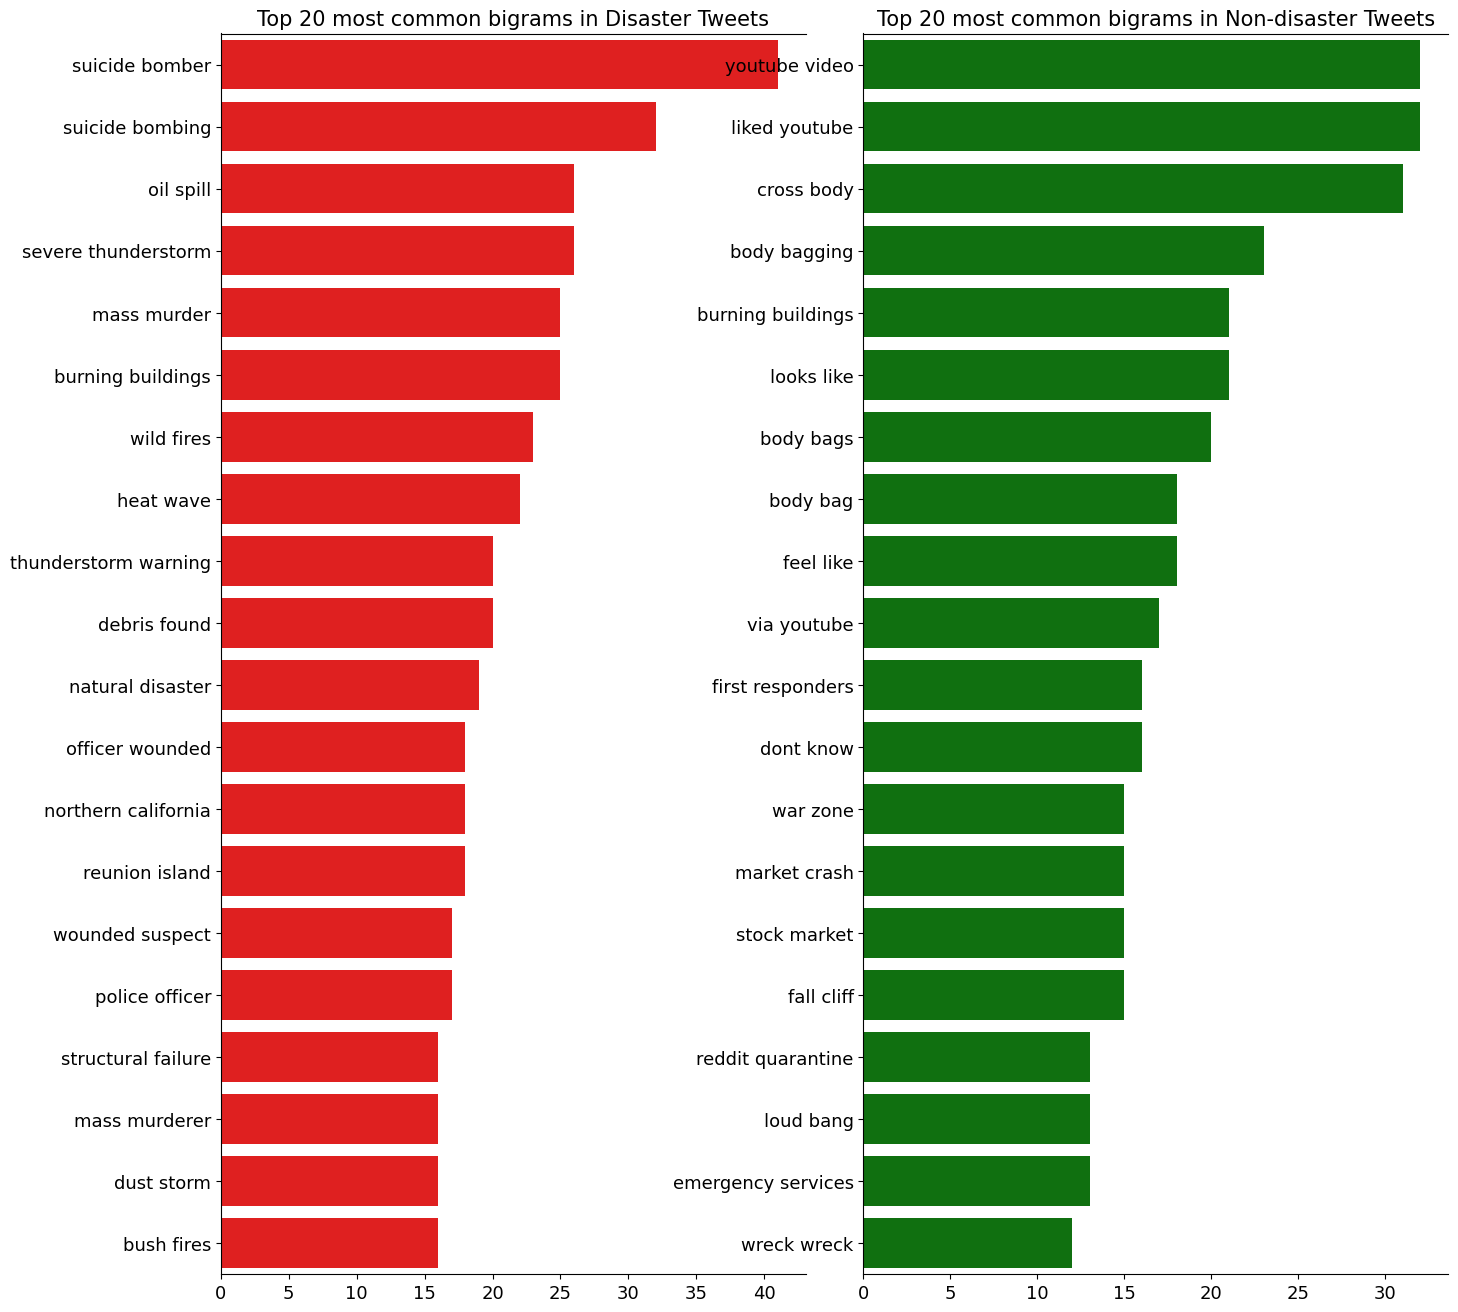

In [135]:

fig, axes = plt.subplots(ncols=2, figsize=(13,13), dpi=100)
plt.tight_layout()

with sns.plotting_context( font_scale=4):
    sns.barplot(y=df_disaster_bigrams[0].values[:N], x=df_disaster_bigrams[1].values[:N], ax=axes[0], color='red')
    sns.barplot(y=df_nondisaster_bigrams[0].values[:N], x=df_nondisaster_bigrams[1].values[:N], ax=axes[1], color='green')

for i in range(2):
    axes[i].spines['right'].set_visible(False)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
    axes[i].tick_params(axis='x', labelsize=13)
    axes[i].tick_params(axis='y', labelsize=13)

axes[0].set_title(f'Top {N} most common bigrams in Disaster Tweets', fontsize=15)
axes[1].set_title(f'Top {N} most common bigrams in Non-disaster Tweets', fontsize=15)

plt.show()

# Unigrams and bigrams Word Cloud

Disaster Unigrams


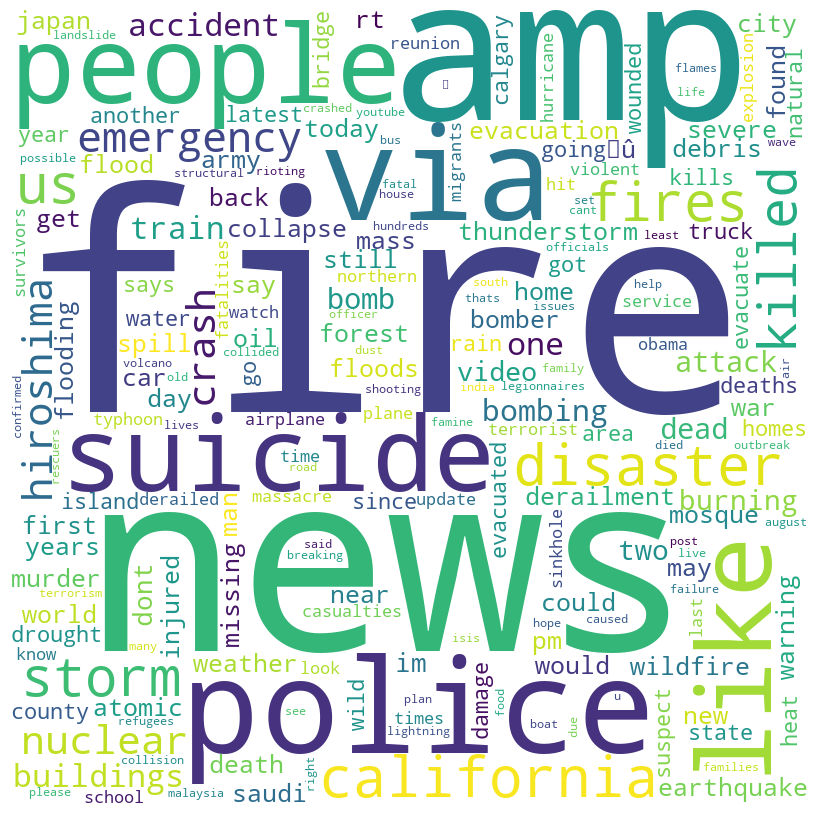

In [151]:
print('Disaster Unigrams')
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate_from_frequencies(dict(zip(df_disaster_unigrams[0], df_disaster_unigrams[1])))

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Non-Disaster Unigrams


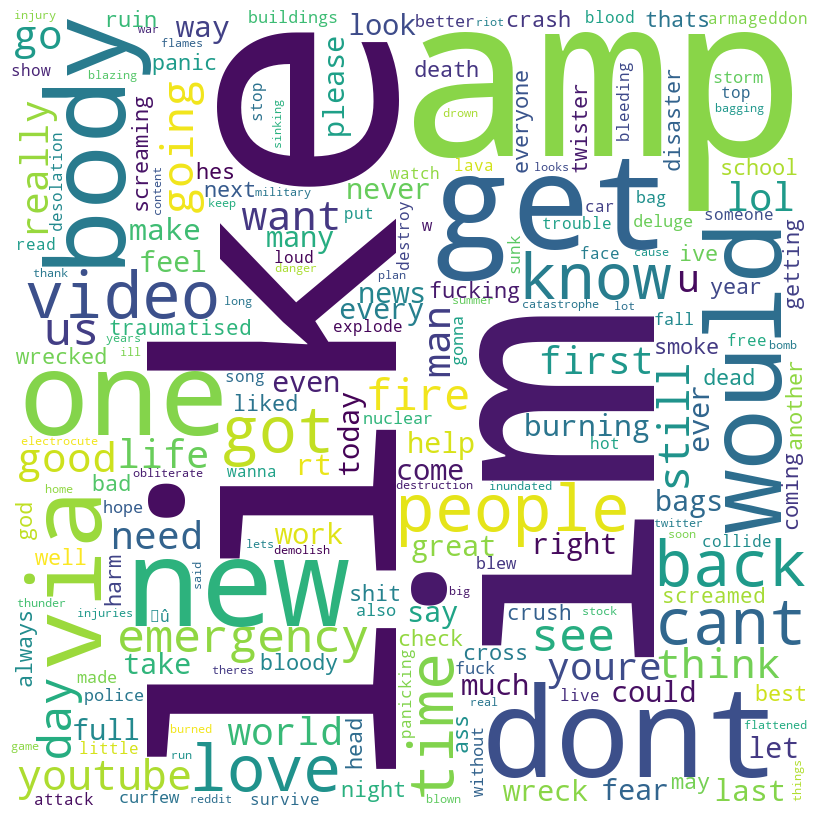

In [152]:
print('Non-Disaster Unigrams')
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate_from_frequencies(dict(zip(df_nondisaster_unigrams[0], df_nondisaster_unigrams[1])))

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Disaster Bigrams


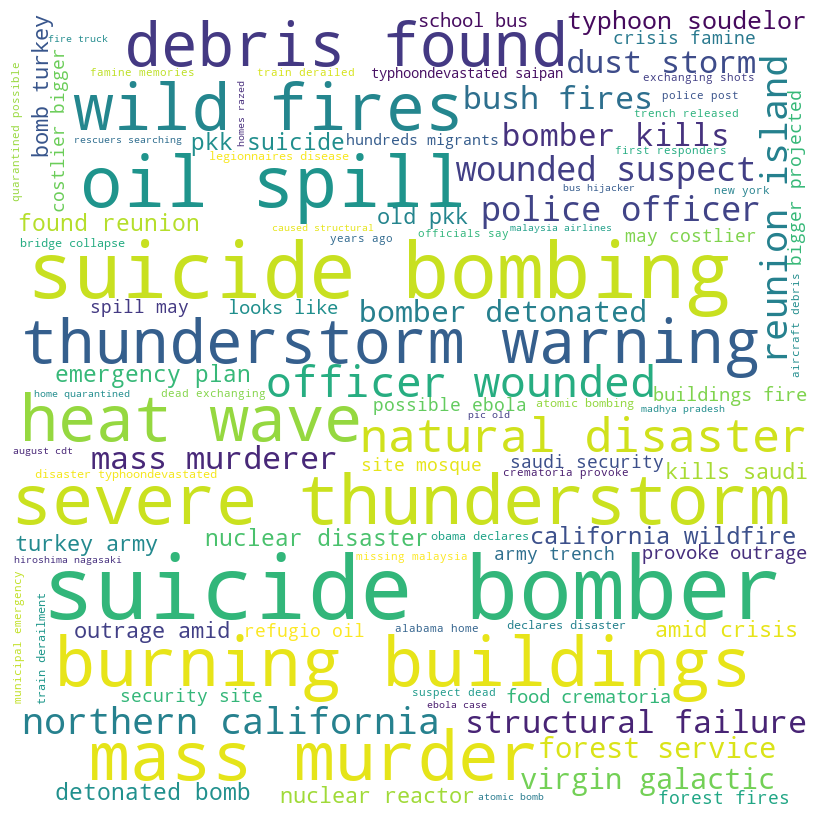

In [153]:
print('Disaster Bigrams')
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate_from_frequencies(dict(zip(df_disaster_bigrams[0], df_disaster_bigrams[1])))

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

Non-Disaster Bigrams


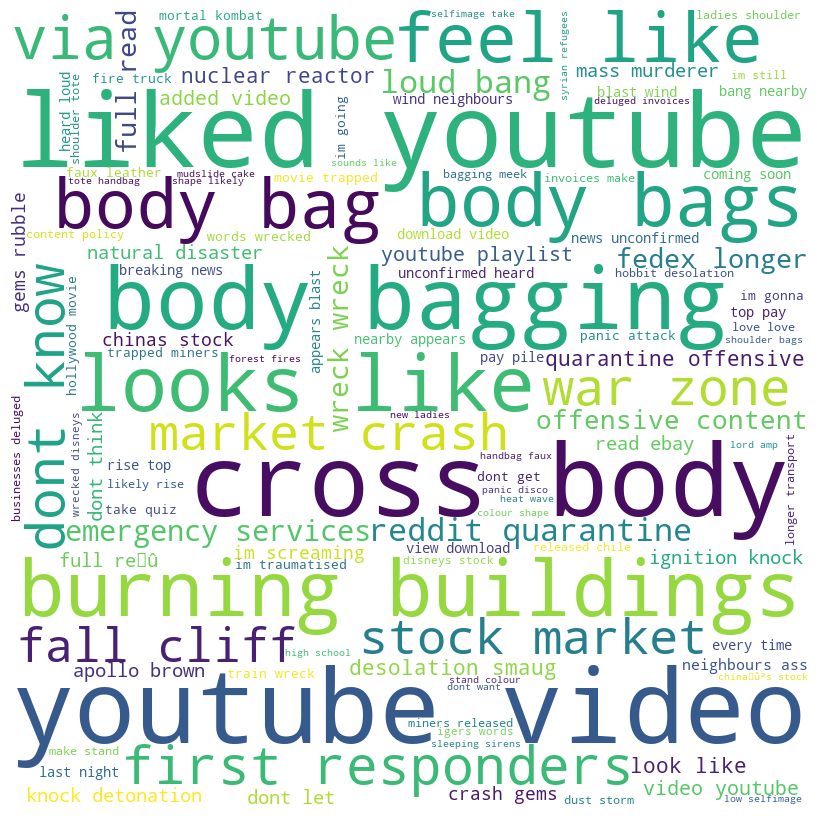

In [154]:
print('Non-Disaster Bigrams')
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800,
                      background_color='white',
                      min_font_size=10).generate_from_frequencies(dict(zip(df_nondisaster_bigrams[0], df_nondisaster_bigrams[1])))

# Display the word cloud
plt.figure(figsize=(8, 8), facecolor=None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

## Density distributions of Meta-Features 

In [188]:
meta_cols = ['word_count', 'unique_word_count', 'stop_word_count', 'mean_word_length', 'char_count', 'punctuation_count', 'url_count', 'hashtag_count', 'mention_count']

In [186]:
# follow same split as classification task

# Define X and y
# X is everything except target, location, keyword, tokenized, and nostopwords_text
X = df.drop(['target', 'keyword','location', 'tokenized', 'nostopwords_text'], axis=1)
y = df['target']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023, stratify=y)

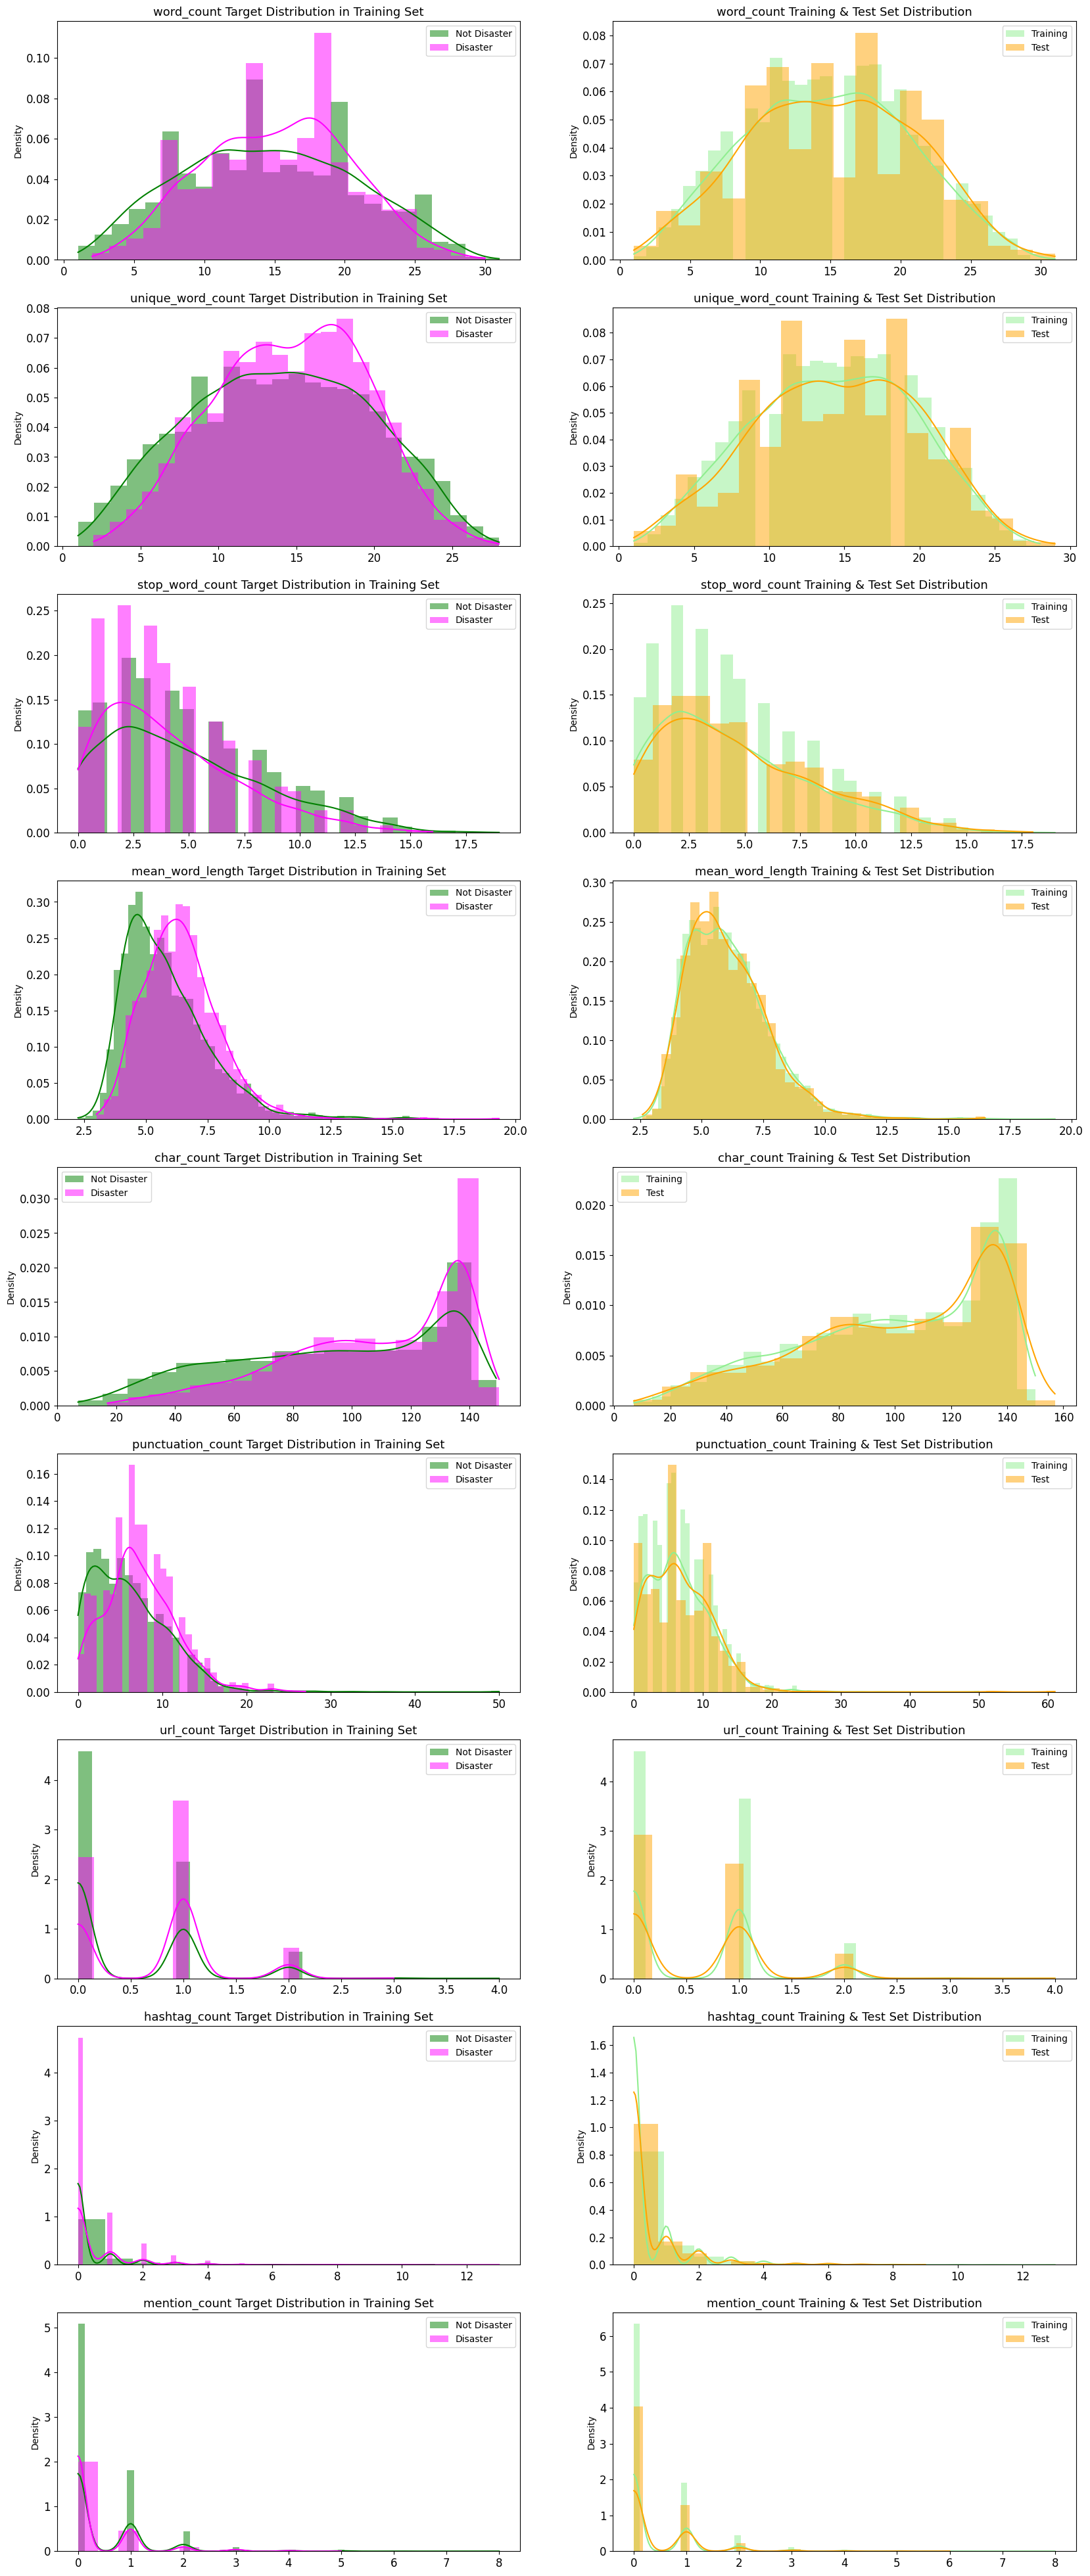

In [198]:

fig, axes = plt.subplots(ncols=2, nrows=len(meta_cols), figsize=(20, 50), dpi=100)

for i, feature in enumerate(meta_cols):
    sns.histplot(X_train.loc[y_train == 0][feature], label='Not Disaster', ax=axes[i][0], color='green', stat= 'density', kde= True, edgecolor= 'None')
    sns.histplot(X_train.loc[y_train == 1][feature], label='Disaster', ax=axes[i][0], color='magenta', stat= 'density', kde= True, edgecolor= 'None')

    sns.histplot(X_train[feature], label='Training', ax=axes[i][1], color= 'lightgreen', stat= 'density', kde= True, edgecolor= 'None')
    sns.histplot(X_test[feature], label='Test', ax=axes[i][1], color= 'orange', stat= 'density', kde= True, edgecolor= 'None')
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()